In [48]:
import re
import numpy as np
import pandas as pd
import gensim
import nltk
from gensim.models import Word2Vec,FastText
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc

In [49]:
data=pd.read_csv(r'D:\CODING\Python\NLP\END_SEM\hindi_data.csv')

In [50]:
data.dropna(inplace=True)

In [51]:
def preprocess_and_clean_hindi(text):

    def preprocess_text_hindi(text):
        tokens = text.split(" ")
        return tokens

    def remove_non_hindi(text):
        hindi_pattern = re.compile("[\u0900-\u097F\s]+")  # Unicode range for Hindi characters and space
        hindi_text = hindi_pattern.findall(text)
        cleaned_text = ''.join(hindi_text)
        return cleaned_text

    tokens = preprocess_text_hindi(text)
    cleaned_text = list(map(remove_non_hindi,tokens))
    # print(cleaned_text)
    return cleaned_text
    
data['text'] = data['text'].apply(preprocess_and_clean_hindi)

In [52]:
data['text']

0       [लोग, वतन, तक, खा, जाते, हैं, इसका, इसे, यकीन,...
1       [गुमनाम, है, वतन, पर, मिटने, वाले, लोग, आतन्कव...
2       [ज़ंजीर, बदली, जा, रही, थी, मैं, समझा, था, रिह...
3       [यूपी, में, बड़े, स्तर, पर, दंगे, करवा, सकती, ...
4       [अंग्रेजी, नहीं, आती, है, इसलिए, हिन्दी, ट्विट...
                              ...                        
2838    [, , याद, रखिये\nनिशाने, पर, न, ब्राह्मण, है, ...
2839    [देखिए, आज, पर, , , एक्सक्लूसिव, रिपोर्ट, माइन...
2840    [सरहद, पर  की, बड़ी, कार्रवाई, , पाक, रेंजर्स,...
2841    [गृहमंत्री, का, जवानो, संग, नया, साल\n, \n, \n...
2842    [दिखावा, है, या, हक़ीक़त, सांसद, आम, आदमी, की,...
Name: text, Length: 2843, dtype: object

In [53]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['sentiment'])
data = data[data['label'] != 2]

y_one_hot = to_categorical(data['label'], num_classes=2)

In [54]:
def load_glove(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        word_embeddings = {}
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_embeddings[word] = vector
    return word_embeddings

def generate_embedding_matrix(word_vector, embedding_model, embedding_type, max_length=200):
    if embedding_type == 'glove':
        embedding_dim = len(next(iter(embedding_model.values())))
        embedding_matrix = np.zeros((max_length, embedding_dim))
        for i, word in enumerate(word_vector):
            if word in embedding_model:
                embedding_matrix[i] = embedding_model[word]
            if i >= max_length - 1:
                break
    else:
        word_embeddings = []
        for word in word_vector:
            if word in embedding_model.wv:
                word_embedding = embedding_model.wv[word]
                word_embeddings.append(word_embedding)
        embedding_matrix = np.array(word_embeddings)
        if len(embedding_matrix) < max_length:
            embedding_matrix = np.pad(embedding_matrix, ((0, max_length - len(embedding_matrix)), (0, 0)), mode='constant')
        else:
            embedding_matrix = embedding_matrix[:max_length, :]
    return embedding_matrix

def train_word2vec(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return Word2Vec(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def train_fasttext(corpus, vector_size=100, window=10, min_count=1, workers=4, sg=1):
    return FastText(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg)

def choose_embedding_model(corpus, model_type, glove_file):
    if model_type == 'word2vec':
        model = train_word2vec(corpus)
    elif model_type == 'fasttext':
        model = train_fasttext(corpus)
    elif model_type == 'glove' and glove_file is not None:
        model = load_glove(glove_file)
    else:
        raise ValueError("Invalid model type or missing GloVe file.")
    return model


In [55]:
tokenized_corpus=data['text'].to_list()

In [56]:
embedding_type = 'fasttext' 
embedding_model = choose_embedding_model(tokenized_corpus, model_type=embedding_type, glove_file=r'D:\CODING\Python\NLP\END_SEM\glove\hindi\vectors.txt')

data['embedding_matrix'] = data['text'].apply(lambda x: generate_embedding_matrix(x, embedding_model, embedding_type))

X = np.array(data['embedding_matrix'].tolist())


X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

input_shape = X_train.shape[1:]

In [57]:
def create_cnn_model(input_shape, num_classes=2):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(512, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l1(0.01)))  # L1 regularization with lambda=0.01
    model.add(Dense(256, activation='relu', kernel_regularizer=l1(0.01)))  # L1 regularization with lambda=0.01
    model.add(Dense(128, activation='relu', kernel_regularizer=l1(0.01)))  # L1 regularization with lambda=0.01
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model = create_cnn_model(input_shape)


d:\ANACONDA\envs\tensorflow\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 198, 64)        │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 97, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 46, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 23, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 21, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 10, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,322,690 (12.68 MB)

 Trainable params: 3,322,690 (12.68 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

Epoch 1/100


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5567 - loss: 451.5635 - val_accuracy: 0.6691 - val_loss: 295.6825
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.6003 - loss: 257.5433 - val_accuracy: 0.6727 - val_loss: 154.3671
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6136 - loss: 132.0800 - val_accuracy: 0.6873 - val_loss: 78.2422
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.6386 - loss: 71.1702 - val_accuracy: 0.5818 - val_loss: 58.0508
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6646 - loss: 52.3633 - val_accuracy: 0.7200 - val_loss: 35.7133
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.7081 - loss: 33.0278 - val_accuracy: 0.7636 - val_loss: 24.5900
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6945 - loss: 22.3673 - val_accuracy: 0.7636 - val_loss: 16.5098
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7570 - loss: 15.1266 - val_accuracy: 0.7345 - 

In [60]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8897 - loss: 3.7659
Test Accuracy: 0.8866279125213623


In [61]:
y_pred_one_hot = model.predict(X_test)

y_pred = np.argmax(y_pred_one_hot, axis=1)
y_true = np.argmax(y_test, axis=1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [62]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.86      0.90       196
           1       0.83      0.92      0.87       148

    accuracy                           0.89       344
   macro avg       0.88      0.89      0.89       344
weighted avg       0.89      0.89      0.89       344



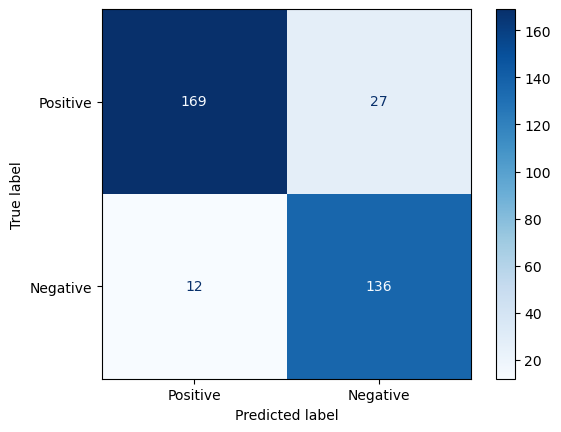

In [63]:
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Positive', 'Negative'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

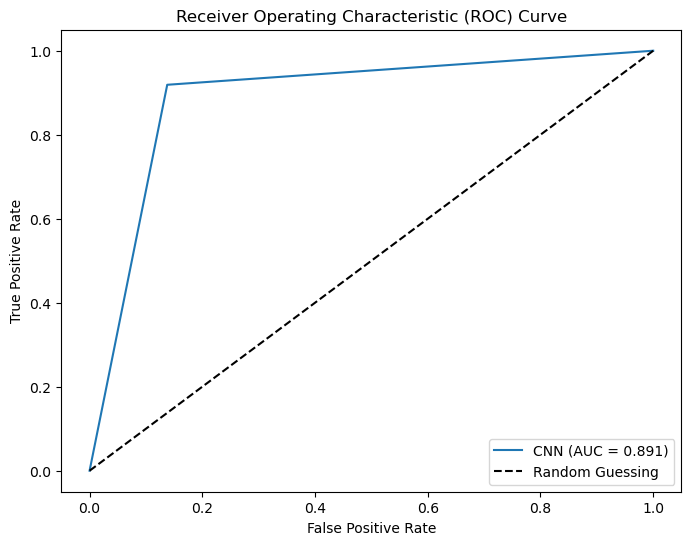

In [64]:
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='CNN (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.show()